------------------------------------------
## ML Models and Predicting FreePass ##

Linear Regression Model

In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier


In [16]:
import pandas as pd
import numpy as np
import textblob as tb
import re

def get_text_features(df):
    """
    Extracts deterministic NLP features from the 'Opinion' column.
    """
    # 1. Clean Text
    # fillna("") ensures we can run string methods even on missing data
    clean_op = (
        df["Opinion"]
        .fillna("")
        .str.lower()
        .str.replace(r"[^a-z\s!?.]", "", regex=True)
        .str.strip()
    )
    
    # 2. Structural Features
    df["op_word_count"] = clean_op.str.split().apply(len)
    
    # 3. Intensity Features
    df["exclam_count"] = clean_op.str.count("!")
    df["qmark_count"] = clean_op.str.count(r"\?")
    
    # 4. Sentiment Features (TextBlob)
    # We use a simple apply; for huge datasets, consider swifter or pandarallel
    df["tb_polarity"] = clean_op.apply(
        lambda x: tb.TextBlob(x).sentiment.polarity if x else 0
    )
    
    # 5. Key Counts (Positive/Negative/Specific words)
    negations = {"not", "never", "no", "nothing", "none"}
    df["negation_count"] = clean_op.apply(lambda x: sum(w in negations for w in x.split()))

    negative_words = {"worst", "disaster", "refund", "ruined", "terrible"}
    df["neg_word_count"] = clean_op.apply(lambda x: sum(w in negative_words for w in x.split()))

    # Specific Keyword Flags (High correlation anchors)
    keywords = ["refund", "worst", "magic", "loved"]
    for kw in keywords:
        df[f"kw_{kw}"] = clean_op.str.contains(rf"\b{kw}\b", regex=True).astype(int)
        
    return df

def split_ticket(ticket):
    try:
        parts = str(ticket).split('/')
        return parts[0], parts[-1] # Returns (TicketType, TicketClass)
    except:
        return 'Unknown', 'Unknown'

def preprocess_csv(path, train_stats=None, save=False, filename=""):
    data = pd.read_csv(path)
    
    
    
    #Opinion polarity
    clean_op = (
        data["Opinion"]
        .fillna("")
        .str.lower()
        .str.replace(r"[^a-z\s!?.]", "", regex=True)
        .str.strip()
    )
    data["tb_polarity"] = data["Opinion"].fillna("").apply(
        lambda x: tb.TextBlob(x).sentiment.polarity if x else 0
    )
    

    # --- 3. Imputation (Train/Test Split Logic) ---
    data[['Ticket_Type', 'Ticket_Class']] = data['TicketInfo'].apply(
        lambda x: pd.Series(split_ticket(x))
    )
    
    # Remove raw text columns now that we have extracted info
    data = data.drop(columns=[ 'Opinion', 'TicketInfo'])
    # Define groups
    # Note: Added new NLP features to num_cols just in case, though they shouldn't have NaNs
    num_cols = [
        'Age',
        'tb_polarity'    ]
    cat_cols = ['PreferedAlbum', 'Vinyl', 'VIP', 'Ticket_Type', 'Ticket_Class','Concert'] 

    if train_stats is None:
        # -- TRAINING MODE --
        train_stats = {} 
        
        # Median for Numbers
        for col in num_cols:
            if col in data.columns:
                val = data[col].median()
                train_stats[col] = val
                data[col] = data[col].fillna(val)
        
        # Mode for Categories
        for col in cat_cols:
            if col in data.columns:
                val = data[col].mode()[0]
                train_stats[col] = val
                data[col] = data[col].fillna(val)
            
    else:
        # -- TEST MODE --
        for col in num_cols:
            if col in train_stats and col in data.columns:
                data[col] = data[col].fillna(train_stats[col])
        
        for col in cat_cols:
            if col in train_stats and col in data.columns:
                data[col] = data[col].fillna(train_stats[col])

    # --- 4. Encoding ---
    
    # One-Hot Encoding
    df_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True)
    
    if save:
        df_encoded.to_csv(filename, index=False)

    return df_encoded, train_stats

In [17]:
import os
path=os.getcwd()
data, stats = preprocess_csv(path+'/train.csv', train_stats=None, save=True, filename=path+'train_cleaned.csv')

# 2. Process Test (using Train stats)
data_test, _ = preprocess_csv(path+'/test.csv', train_stats=stats, save=True, filename=path+'test_cleaned.csv')

# 3. CRITICAL FIX: Force Test columns to match Train columns
# This adds missing columns (filled with 0) and deletes extra ones (that were not in Train)
data_test = data_test.reindex(columns=data.columns, fill_value=0)

C:\Users\Ale\AppData\Local\Temp\ipykernel_6356\374972845.py:102: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(val)
C:\Users\Ale\AppData\Local\Temp\ipykernel_6356\374972845.py:112: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].fillna(train_stats[col])


In [19]:
data.head()

,Id,AvgTime,Age,Food,Drinks,FreePass,tb_polarity,PreferedAlbum_Head Hunters,PreferedAlbum_Kind of Blue,Vinyl_True,...,Ticket_Type_LB,Ticket_Type_LT,Ticket_Type_PB,Ticket_Type_RB,Ticket_Type_RT,Ticket_Type_nan,Ticket_Class_XL,Ticket_Class_nan,Concert_NYC12-5pm,Concert_SF14-7pm
0,01/2362,3.055,22.0,170.0,1.0,True,0.100000,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,04/0599,2.510,9.0,0.0,0.0,True,-0.166667,False,False,True,...,True,False,False,False,False,False,False,False,True,False
2,01/3223,0.803,27.0,815.0,37.0,False,-0.125000,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,01/1966,0.568,36.0,1427.0,1395.0,False,0.000000,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,01/8850,0.034,16.0,1299.0,0.0,False,0.000000,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [18]:
data.columns

Index(['Id', 'AvgTime', 'Age', 'Food', 'Drinks', 'FreePass', 'tb_polarity',
       'PreferedAlbum_Head Hunters', 'PreferedAlbum_Kind of Blue',
       'Vinyl_True', 'VIP_True', 'Ticket_Type_B', 'Ticket_Type_CB',
       'Ticket_Type_LB', 'Ticket_Type_LT', 'Ticket_Type_PB', 'Ticket_Type_RB',
       'Ticket_Type_RT', 'Ticket_Type_nan', 'Ticket_Class_XL',
       'Ticket_Class_nan', 'Concert_NYC12-5pm', 'Concert_SF14-7pm'],
      dtype='object')

In [ ]:

cols_to_drop=["Id", "FreePass", "AvgTime"]
             

X = data.drop(columns=cols_to_drop)
Y=data["FreePass"]
IDs=data["Id"]
data_test_IDs = data_test["Id"]
#X_test_ext = data_test.drop(columns=["Id"])
X_test_ext = data_test.drop(columns=cols_to_drop)
randstate=np.random.randint(0,1000)
print(randstate)

# 100 -> 70/30 #
X_train, X_hold, Y_train, Y_hold, ID_train, ID_hold = train_test_split(
    X,Y,IDs,
    test_size=0.3,
    random_state=randstate,
    stratify=Y
)

# 30 -> 15/15 #
X_val, X_test, Y_val, Y_test, ID_val, ID_test = train_test_split(
    X_hold,Y_hold,ID_hold,
    test_size=0.5,
    random_state=randstate,
    stratify=Y_hold
)


63


{'train_mse': 0.15391819132342804,
 'val_mse': 0.1579566731766071,
 'test_mse': 0.15525765374986683,
 'train_auc': 0.8625675860202044,
 'val_auc': 0.8683464690223915,
 'test_auc': 0.8616102379649179}

In [ ]:

def eval_model(model, x, y=None, threshold=0.5):
    score = model.predict_proba(x)[:,1]
    output = score >= threshold
    metrics={}
    if y is not None:
        metrics["roc_auc"]=roc_auc_score(y,score)
    return score, output, metrics

def train_model(model, x_train, y_train):
    model.fit(x_train, y_train)
    return model



In [ ]:
grad_boost_tree = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=randstate
)

model_grad_boost_tree = train_model(grad_boost_tree, X, Y)
eval_model(model_grad_boost_tree, X, Y)

scores2,output2,metrics2 = eval_model(model_grad_boost_tree, X_test, Y_test)
print(metrics2)

{'roc_auc': 0.9833546189868029}


In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 1. Setup Cross-Validation (5 folds is standard)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randstate)

# 2. Define a more conservative model to prevent overfitting
# max_depth=6 is often too deep for small data. Try 3 or 4.
grad_boost_tree = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05, # Lower learning rate often generalizes better
    max_depth=3,        # Shallower trees prevent memorization
    subsample=0.8,      # Uses only 80% of data per tree (adds robustness)
    random_state=randstate
)

# 3. Evaluate using CV (This is your REAL performance metric)
cv_scores = cross_val_score(grad_boost_tree, X_train, Y_train, cv=cv, scoring='roc_auc')

print(f"CV AUC Scores: {cv_scores}")
print(f"Average CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 4. Only if CV is good, train on full training set and predict
grad_boost_tree.fit(X_train, Y_train)

# Check on your hold-out set (Validation)
val_pred = grad_boost_tree.predict_proba(X_val)[:, 1]
print(f"Validation AUC: {roc_auc_score(Y_val, val_pred):.4f}")

CV AUC Scores: [0.90108701 0.90353948 0.88501038 0.9049992  0.8927563 ]
Average CV AUC: 0.8975 (+/- 0.0075)
Validation AUC: 0.9083


In [52]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1. Define the parameter grid to test
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],            # Keep it low to prevent overfitting
    'subsample': [0.8, 1.0]            # Fraction of samples used for fitting each tree
}

# 2. Setup Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=randstate)

# 3. Initialize Grid Search
#    scoring='roc_auc' optimizes the ranking quality
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=randstate),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# 4. Run Search (Only on X_train to avoid leakage)
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# Save the best model for the next steps
best_model = grid_search.best_estimator_

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best CV AUC: 0.8975


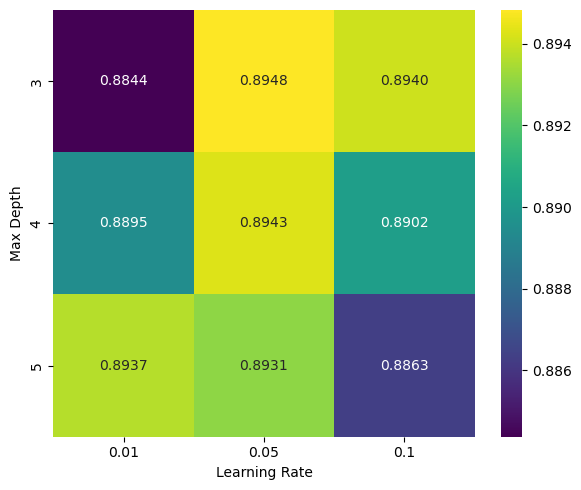

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract results
results = pd.DataFrame(grid_search.cv_results_)

# Pivot data for heatmap (Learning Rate vs Max Depth)
# We aggregate by taking the mean score for each pair
heatmap_data = results.pivot_table(
    index='param_max_depth', 
    columns='param_learning_rate', 
    values='mean_test_score'
)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".4f")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

Optimal Threshold: 0.36
Validation Accuracy at optimal: 0.8194


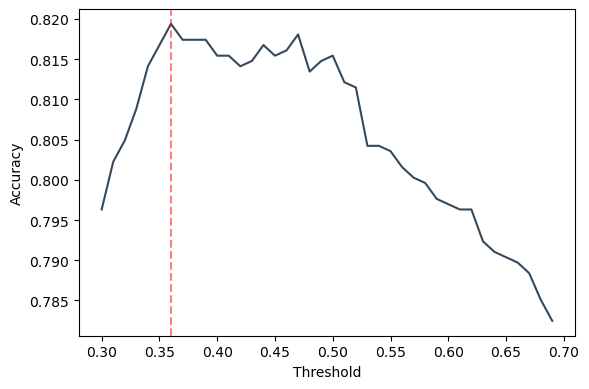

In [54]:
from sklearn.metrics import accuracy_score

# Get probabilities from the optimized model
val_probs = best_model.predict_proba(X_val)[:, 1]

# Search for the threshold that maximizes Accuracy (since Kaggle demands True/False)
best_threshold = 0.5
best_acc = 0

thresholds = np.arange(0.3, 0.7, 0.01)
accuracies = []

for tr in thresholds:
    preds = (val_probs >= tr)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_threshold = tr

print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Validation Accuracy at optimal: {best_acc:.4f}")

# Optional: Plot threshold curve
plt.figure(figsize=(6, 4))
sns.lineplot(x=thresholds, y=accuracies, color="#34495e")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.axvline(best_threshold, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [55]:
# 1. Refit the BEST estimator on the FULL dataset (Train + Val + Hold)
print("Retraining best model on full dataset...")
best_model.fit(X, Y) 

# 2. Predict Probabilities on Test Data
final_probs = best_model.predict_proba(X_test_ext)[:, 1]

# 3. Apply the Optimized Threshold
final_preds = (final_probs >= best_threshold)

# 4. Save
output_df = (
    data_test_IDs
    .to_frame(name="Id")
    .assign(FreePass=final_preds)
)

filename = f"submission_gridsearch_depth{grid_search.best_params_['max_depth']}_tr{best_threshold:.2f}.csv"
path_save = os.path.join(os.getcwd(), "results", filename)
output_df.to_csv(path_save, index=False)

print(f"Saved: {filename}")

Retraining best model on full dataset...
Saved: submission_gridsearch_depth5_tr0.36.csv


In [37]:
gradboosttree_coef = pd.Series(grad_boost_tree.feature_importances_, index=X_train.columns)
gbt=gradboosttree_coef.sort_values(ascending=False)
gbt

Vinyl_True                    0.369820
Drinks                        0.181206
Food                          0.142828
Age                           0.078365
tb_polarity                   0.065271
PreferedAlbum_Kind of Blue    0.042352
PreferedAlbum_Head Hunters    0.035225
Ticket_Class_XL               0.017647
Ticket_Type_B                 0.015367
Ticket_Type_CB                0.014005
Concert_NYC12-5pm             0.011103
Ticket_Type_LB                0.007082
Concert_SF14-7pm              0.005385
Ticket_Type_LT                0.004958
Ticket_Type_PB                0.002483
VIP_True                      0.002131
Ticket_Type_RB                0.001601
Ticket_Class_nan              0.001588
Ticket_Type_nan               0.001563
Ticket_Type_RT                0.000020
dtype: float64

In [38]:
leak_check = X_train.assign(FreePass=Y_train)

corr = leak_check.corr()["FreePass"].abs().sort_values(ascending=False)
corr.head(10)

FreePass                      1.000000
Vinyl_True                    0.536155
Drinks                        0.299364
PreferedAlbum_Kind of Blue    0.163321
PreferedAlbum_Head Hunters    0.147846
Ticket_Type_B                 0.118739
Ticket_Type_LB                0.110629
Concert_NYC12-5pm             0.104070
Ticket_Type_LT                0.095788
tb_polarity                   0.090401
Name: FreePass, dtype: float64

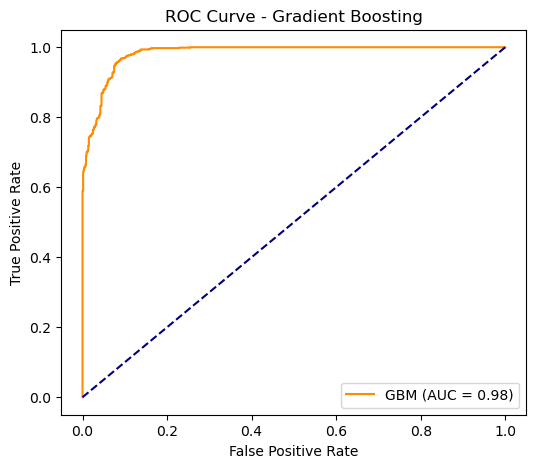

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC for Gradient Boosting
fpr, tpr, _ = roc_curve(Y_test, scores2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', label=f'GBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

## TODO: ##

- Split data (pipeline) train test validation
- First submission: regression models
    - preprocess test.csv
    - using test data
- Later models
    - classifiers of various types: tree, boosted tree, randomforest etc

What im doing: 
-Data leakage: we fill the nan values of the test with test statistics. kind of cheating. I fill them with train statistics. -- Slightly got worse submission:  0.82597 from  0.82597.

-Plot to see AUC with different models

-I dropped concert subdivisions in time, city... in histogram there are only 3 values then i resversed cause it didnt improve.

-I tried to remove food and drinks thinking it was maybe inferring causality. didnt work they are legit signal

-I scanned through different parameters but AUC is still not improving. seems like parameters for GBT were already intelligently chosen. Downloaded catboost but its also not improving significantly.

-maybe the answer is still in the opinion? try to give more dimensions appart from positivity.
-i tried to get many extra features from opinion but doing so doesnt really increase auc

